In [1]:
import os
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from collections import Counter
import json

# Create results directory
os.makedirs('results', exist_ok=True)
print("✅ Results directory created")

✅ Results directory created


In [2]:
# Let's look DEEPER into the NSFW dataset
nsfw_path = Path('datasets/raw/nsfw_detection')

print("NSFW Dataset DEEP Exploration:")
print("="*60)

# Find ALL files recursively
all_files = list(nsfw_path.rglob('*'))
print(f"Total files found: {len(all_files)}")

# Separate by type
images = [f for f in all_files if f.suffix.lower() in ['.jpg', '.jpeg', '.png', '.gif', '.bmp']]
csvs = [f for f in all_files if f.suffix.lower() == '.csv']
other = [f for f in all_files if f not in images and f not in csvs and f.is_file()]

print(f"\nImages: {len(images)}")
print(f"CSV files: {len(csvs)}")
print(f"Other files: {len(other)}")

# Show directory structure
print("\nDirectory structure:")
for i, f in enumerate(all_files[:20]):  # First 20 items
    rel_path = f.relative_to(nsfw_path)
    file_type = "DIR" if f.is_dir() else f.suffix
    print(f"  {rel_path} ({file_type})")
if len(all_files) > 20:
    print(f"  ... and {len(all_files)-20} more")

# Check CSV files
if csvs:
    print(f"\n{'='*60}")
    print("CSV Files Found:")
    print('='*60)
    for csv_file in csvs:
        print(f"\n{csv_file.name}:")
        df = pd.read_csv(csv_file)
        print(f"  Shape: {df.shape}")
        print(f"  Columns: {list(df.columns)}")
        print(f"\nFirst 3 rows:")
        print(df.head(3))
        
        # Check for label column
        potential_label_cols = [col for col in df.columns if 'label' in col.lower() or 'class' in col.lower() or 'category' in col.lower()]
        if potential_label_cols:
            print(f"\nLabel columns: {potential_label_cols}")
            for col in potential_label_cols:
                print(f"\n{col} distribution:")
                print(df[col].value_counts())

NSFW Dataset DEEP Exploration:
Total files found: 27741

Images: 27731
CSV files: 0
Other files: 0

Directory structure:
  out (DIR)
  out/test (DIR)
  out/val (DIR)
  out/train (DIR)
  out/test/NSFW (DIR)
  out/test/Neutral (DIR)
  out/val/NSFW (DIR)
  out/val/Neutral (DIR)
  out/train/NSFW (DIR)
  out/train/Neutral (DIR)
  out/test/NSFW/cocaine_image02-12-_jpg.rf.4e09950aee7a401cf88d1ae2473aca9f.jpg (.jpg)
  out/test/NSFW/prefix_GantMan_8F9B9C8C-6A70-4BF4-A6B4-64E923B04798-jpg_jpeg.rf.4f015b6db145e38fea22b137d8358b50.jpg (.jpg)
  out/test/NSFW/cocaine_image8-2-_jpg.rf.bd0da1790190f0150918e6106e74f269.jpg (.jpg)
  out/test/NSFW/blood_440_jpg.rf.7856220160082e2158ff2916328fa3d8.jpg (.jpg)
  out/test/NSFW/images-2023-10-03T123423-254_jpg.rf.6c192a9c0839af32cc1afe097b5cf672.jpg (.jpg)
  out/test/NSFW/prefix_GantMan_7EA2B936-283E-43B9-9536-7C60ED9B5981-jpg_jpeg.rf.d4326b9e99c4003f06112dd7d8a7adec.jpg (.jpg)
  out/test/NSFW/images-2023-10-03T123439-392_jpg.rf.589dee1ecd69c679e4a727be284148

In [3]:
violence_path = Path('datasets/raw/violence_safe')

print("\n" + "="*60)
print("Violence/Safe Dataset:")
print("="*60)

# We know the structure from your output
violent_imgs = list((violence_path / 'Graphically Violent Images').glob('*'))
safe_imgs = list((violence_path / 'Graphically Safe Images').glob('*'))

print(f"\nGraphically Violent Images: {len(violent_imgs)}")
print(f"Graphically Safe Images: {len(safe_imgs)}")
print(f"Total: {len(violent_imgs) + len(safe_imgs)}")

# Show some file names
print("\nSample violent image names:")
for img in violent_imgs[:5]:
    print(f"  - {img.name}")

print("\nSample safe image names:")
for img in safe_imgs[:5]:
    print(f"  - {img.name}")


Violence/Safe Dataset:

Graphically Violent Images: 66
Graphically Safe Images: 1102
Total: 1168

Sample violent image names:
  - main-qimg-5ef7db24fc080cb4c1d16064767d2d2f-lq.jpg
  - images (8).jpg
  - images (4).jpg
  - images (37).jpg
  - download (3).jpg

Sample safe image names:
  - motivational images_73.jpeg
  - motivational images_15.jpeg
  - funny images_18.jpeg
  - political images_56.jpeg
  - motivational images_97.jpeg


In [4]:
# Let's create a unified view of what we have

dataset_info = []

# Violence dataset
violence_path = Path('datasets/raw/violence_safe')
for img_path in (violence_path / 'Graphically Violent Images').glob('*'):
    if img_path.suffix.lower() in ['.jpg', '.jpeg', '.png', '.gif']:
        dataset_info.append({
            'image_path': str(img_path),
            'label': 'unsafe',
            'category': 'violence',
            'source': 'violence_safe'
        })

for img_path in (violence_path / 'Graphically Safe Images').glob('*'):
    if img_path.suffix.lower() in ['.jpg', '.jpeg', '.png', '.gif']:
        dataset_info.append({
            'image_path': str(img_path),
            'label': 'safe',
            'category': 'safe',
            'source': 'violence_safe'
        })

print(f"Violence dataset: {len(dataset_info)} images")

# NSFW dataset - we'll add once we understand structure
nsfw_path = Path('datasets/raw/nsfw_detection')
nsfw_images = list(nsfw_path.rglob('*.jpg')) + list(nsfw_path.rglob('*.png')) + list(nsfw_path.rglob('*.jpeg'))

print(f"NSFW dataset: {len(nsfw_images)} images found")

# For now, let's see if there's a CSV that tells us labels
nsfw_csvs = list(nsfw_path.rglob('*.csv'))
if nsfw_csvs:
    print(f"\nFound {len(nsfw_csvs)} CSV files in NSFW dataset")
    print("We'll use these to get labels")
else:
    print("\nNo CSV found - images might be in labeled folders we need to find")

# Create DataFrame
df = pd.DataFrame(dataset_info)
print(f"\n{'='*60}")
print("Current Dataset Summary:")
print('='*60)
print(f"Total images: {len(df)}")
print(f"\nLabel distribution:")
print(df['label'].value_counts())
print(f"\nCategory distribution:")
print(df['category'].value_counts())

# Save
df.to_csv('datasets/metadata/combined_dataset.csv', index=False)
print(f"\n✅ Saved metadata to datasets/metadata/combined_dataset.csv")

Violence dataset: 1166 images
NSFW dataset: 27731 images found

No CSV found - images might be in labeled folders we need to find

Current Dataset Summary:
Total images: 1166

Label distribution:
label
safe      1101
unsafe      65
Name: count, dtype: int64

Category distribution:
category
safe        1101
violence      65
Name: count, dtype: int64

✅ Saved metadata to datasets/metadata/combined_dataset.csv


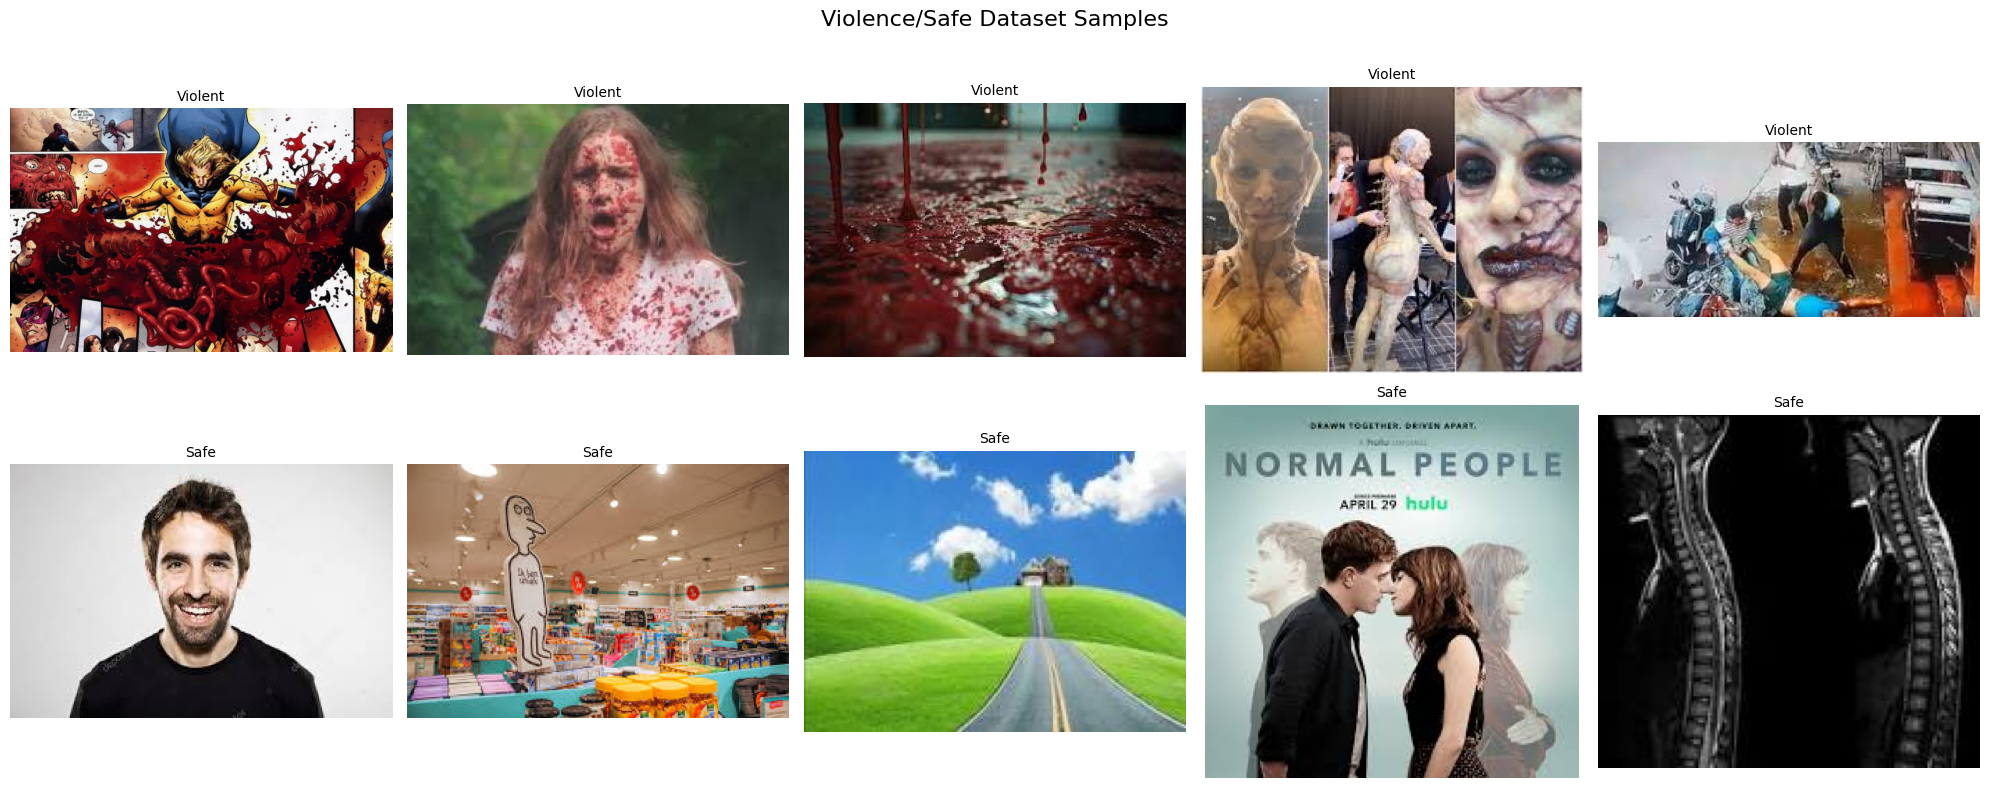

✅ Saved visualization to results/violence_dataset_samples.png


In [5]:
# Visualize samples from violence dataset
fig, axes = plt.subplots(2, 5, figsize=(20, 8))

violence_path = Path('datasets/raw/violence_safe')

# Row 1: Violent images
violent_imgs = list((violence_path / 'Graphically Violent Images').glob('*.jpg'))[:5]
for idx, (ax, img_path) in enumerate(zip(axes[0], violent_imgs)):
    try:
        img = Image.open(img_path)
        ax.imshow(img)
        ax.set_title(f"Violent", fontsize=10)
        ax.axis('off')
    except Exception as e:
        ax.text(0.5, 0.5, f'Error loading', ha='center')
        ax.axis('off')

# Row 2: Safe images  
safe_imgs = list((violence_path / 'Graphically Safe Images').glob('*.jpg'))[:5]
for idx, (ax, img_path) in enumerate(zip(axes[1], safe_imgs)):
    try:
        img = Image.open(img_path)
        ax.imshow(img)
        ax.set_title(f"Safe", fontsize=10)
        ax.axis('off')
    except Exception as e:
        ax.text(0.5, 0.5, f'Error loading', ha='center')
        ax.axis('off')

plt.suptitle('Violence/Safe Dataset Samples', fontsize=16)
plt.tight_layout()
plt.savefig('results/violence_dataset_samples.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Saved visualization to results/violence_dataset_samples.png")